In [6]:
import netCDF4 as nc
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import glob
from geopy.distance import geodesic

In [7]:
halo_files = sorted(glob.glob('2023*CH4.h5'))
halo_files

['20230726_F1_subCH4.h5',
 '20230726_F2_subCH4.h5',
 '20230728_F1_subCH4.h5',
 '20230728_F2_subCH4.h5',
 '20230805_F1_subCH4.h5',
 '20230809_F1_subCH4.h5']

In [10]:
f = File(halo_files[0],'r')
xch4 = f['CH4DataProducts']['XCH4_clear'][:]
good_inds = np.where(1-np.isnan(xch4))
lat = f["Nav_Data"]['gps_lat'][:][good_inds]
lon = f['Nav_Data']['gps_lon'][:][good_inds]
t = f['Nav_Data']['gps_time'][:][good_inds]
alt = f['Nav_Data']['gps_alt'][:][good_inds]


In [11]:
len(lat)

15292

<HDF5 dataset "XCH4_clear": shape (27316, 1), type "<f8">

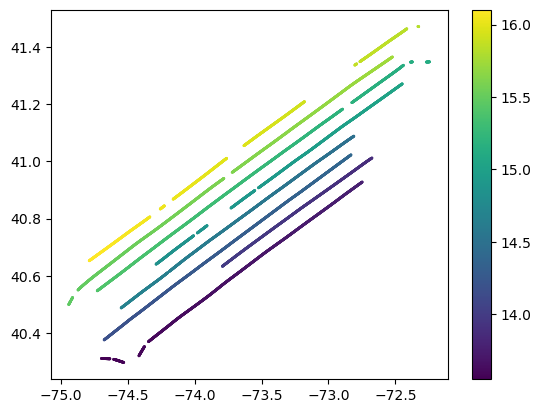

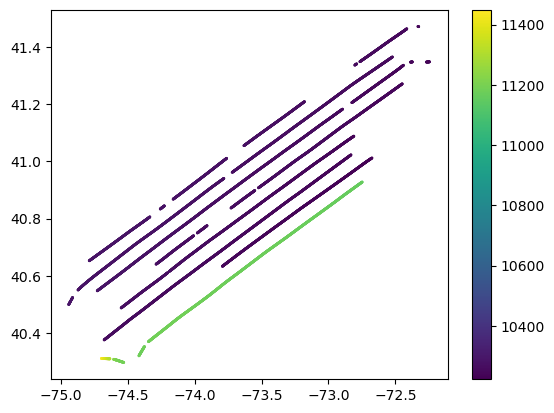

In [12]:
t_inds = np.where((t>13.55)*(t<16.11))
plt.scatter(lon[t_inds],lat[t_inds],c=t[t_inds],s=1); plt.colorbar()
plt.figure()
plt.scatter(lon[t_inds],lat[t_inds],c=alt[t_inds],s=1); plt.colorbar()


In [29]:
geodesic((lon[t_inds[0][0]],lat[t_inds[0][0]]),(lon[t_inds[0][1]],lat[t_inds[0][1]])).km

0.3022759865107993

/tmp/ipykernel_2511647/529542525.py:27: RuntimeWarning: Mean of empty slice
  xch4_avg.append(np.nanmean(tch4[jnds]))


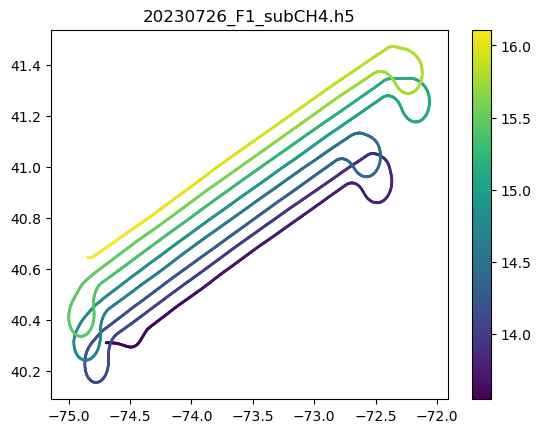

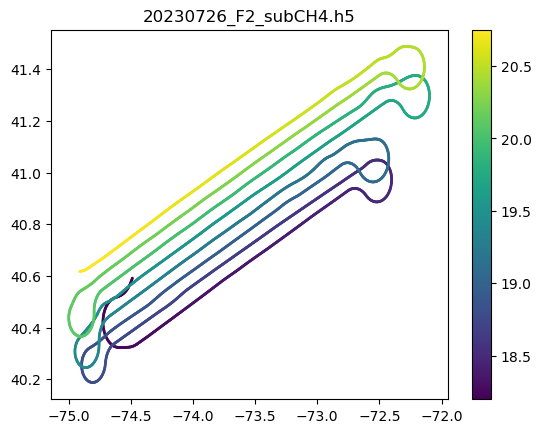

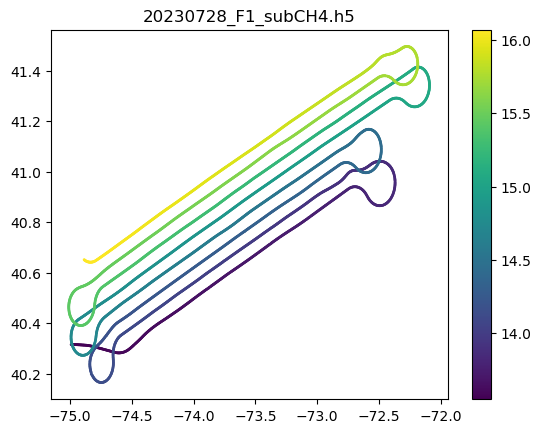

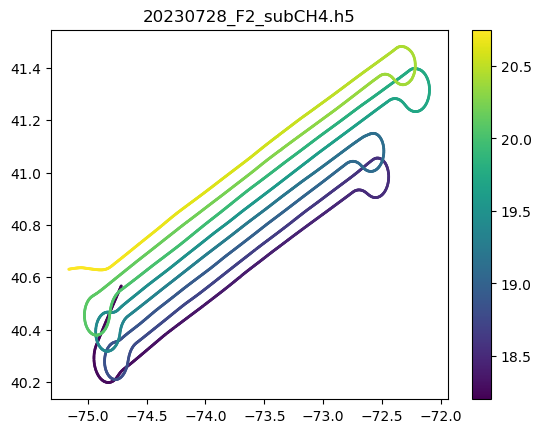

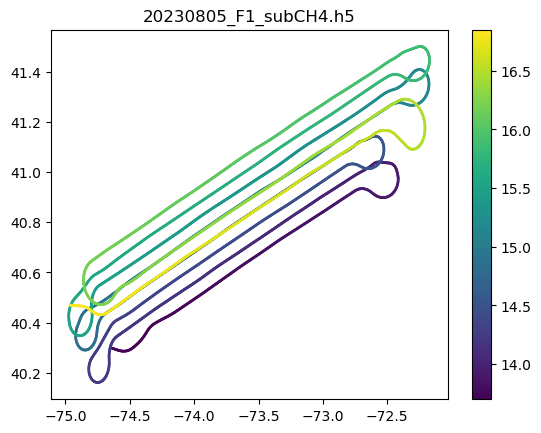

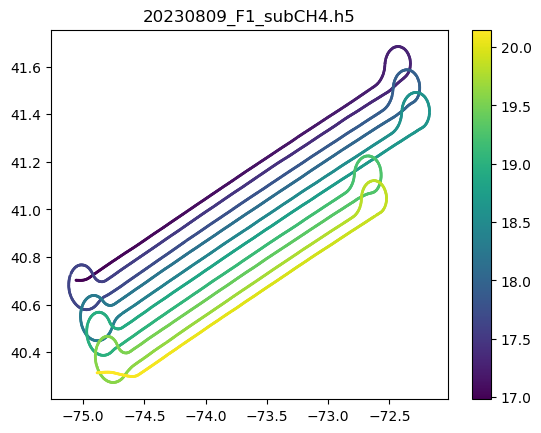

In [14]:
dx = 300
t_lims = [[13.55,16.11],[18.2,20.75],[13.55,16.07],[18.2,20.75],[13.7,16.85],[16.98,20.15]]
for ifi,fi in zip(range(6),halo_files[:]):
    lon_avg,lat_avg,t_avg,xch4_avg = [],[],[],[]
    fid = nc.Dataset(fi,'r')
    xch4 = fid['CH4DataProducts']['XCH4_clear'][:]
    good_inds = range(len(xch4))#np.where(1-np.isnan(xch4))
    t = fid['Nav_Data']['gps_time'][:][good_inds]
    lat = fid['Nav_Data']['gps_lat'][:][good_inds]
    lon = fid['Nav_Data']['gps_lon'][:][good_inds]
    xch4 = xch4[good_inds]
    
    inds = np.where((t > t_lims[ifi][0])*(t < t_lims[ifi][1]))[0]
    tlat = lat[inds]
    tlon = lon[inds]
    tt = t[inds]
    tch4 = xch4[inds]
    ii = 0
    while ii < len(inds)-1:
        ub = min((200,len(inds)-ii-1))
        dd = np.array([geodesic((tlat[ii],tlon[ii]),(tlat[ii+jj],tlon[ii+jj])).m for jj in range(1,ub)])
        jnds = [ii]
        jnds.extend(ii+np.where(dd < dx)[0])
        lon_avg.append(tlon[jnds].mean())
        lat_avg.append(tlat[jnds].mean())
        t_avg.append(tt[jnds].mean())
        xch4_avg.append(np.nanmean(tch4[jnds]))
        ii += np.max((1,len(jnds)))

    t_avg = np.array(t_avg)
    lat_avg = np.array(lat_avg)
    lon_avg = np.array(lon_avg)
    xch4_avg = np.array(xch4_avg)

    fname = fi.split('/')[-1].split('.h5')[0]
    f = File(f'{fname}_{dx}m.h5','w')
    f.create_dataset('lat',data=lat_avg[:])
    f.create_dataset('lon',data=lon_avg[:])
    f.create_dataset('time',data=t_avg[:])
    f.create_dataset('xch4',data=xch4_avg[:])
    
    f.close()
    plt.figure(); plt.scatter(lon_avg,lat_avg,c=t_avg,s=1); plt.colorbar(); plt.title(fi);